In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from collections import deque
import random

In [ ]:
class OriginalHebbianGNN_Actor(nn.Module):
    """
    Upgraded Actor: Sensory Clusters + Dynamic Topology Rewiring
    """
    def __init__(self, state_dim, num_nodes, hidden_dim, action_dim):
        super().__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        # --- NEW: Sensory Segmentation (Creating Clusters) ---
        # Instead of every node seeing everything, we split the brain.
        # Half the nodes see the first half of state inputs (e.g. Position)
        # The other half see the rest (e.g. Velocity)
        self.split_idx = state_dim // 2
        dim_1 = self.split_idx
        dim_2 = state_dim - self.split_idx
        
        # We assign nodes 0 to half to input 1, and half to end to input 2
        self.nodes_part_1 = num_nodes // 2
        self.nodes_part_2 = num_nodes - self.nodes_part_1
        
        # Specific encoders for specific clusters
        self.input_proj_1 = nn.Linear(dim_1, self.nodes_part_1 * hidden_dim)
        self.input_proj_2 = nn.Linear(dim_2, self.nodes_part_2 * hidden_dim)
        
        # Adjacency matrix (logits)
        self.adj_logits = nn.Parameter(torch.randn(num_nodes, num_nodes) * 0.3)
        
        # Hebbian edge weights
        self.register_buffer('edge_weights', torch.ones(num_nodes, num_nodes) * 0.5)
        
        # Message passing
        self.message_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Actor head
        self.actor_head = nn.Sequential(
            nn.Linear(num_nodes * hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh()
        )
        
        # Hebbian & Rewiring Params
        self.hebbian_lr = 0.01
        self.oja_alpha = 0.01
        self.adj_threshold = 0.4
        
        # Rewiring Thresholds
        self.grow_threshold = 0.75 # If correlation > this, grow edge
        self.prune_threshold = 0.05 # If weight < this, kill edge
        
    def get_adjacency(self):
        adj = torch.sigmoid(self.adj_logits)
        return adj * (adj > self.adj_threshold).float()
    
    def forward(self, state, apply_hebbian=True):
        batch_size = state.shape[0]
        
        # Cluster-based Input Processing
        # Split the state vector
        s1 = state[:, :self.split_idx]
        s2 = state[:, self.split_idx:]
        
        # Process separately (Local knowledge)
        feat_1 = self.input_proj_1(s1).view(batch_size, self.nodes_part_1, self.hidden_dim)
        feat_2 = self.input_proj_2(s2).view(batch_size, self.nodes_part_2, self.hidden_dim)
        
        # Concatenate to form the full set of nodes
        node_features = torch.cat([feat_1, feat_2], dim=1) # [Batch, Num_Nodes, Hidden]
        
        # Get adjacency
        adj = self.get_adjacency()
        effective_weights = adj * self.edge_weights
        
        # Message passing (2 rounds)
        for _ in range(2):
            messages = self.message_pass(node_features, effective_weights)
            node_features = node_features + 0.5 * messages
        
        # NEW: Dynamic Topology Update
        if apply_hebbian and self.training:
            self.hebbian_update(node_features, adj > 0)
            self.dynamic_topology_rewire(node_features)
        
        # Actor output
        graph_embedding = node_features.reshape(batch_size, -1)
        actions = self.actor_head(graph_embedding)
        
        return actions, adj
    
    def message_pass(self, node_features, edge_weights):
        batch_size, num_nodes, hidden_dim = node_features.shape
        messages = torch.zeros_like(node_features)
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j:
                    # Optimize speed slightly by using matrix multiplication if possible
                    # but loop is fine for small num_nodes
                    edge_input = torch.cat([node_features[:, j], node_features[:, i]], dim=-1)
                    message = self.message_mlp(edge_input)
                    messages[:, i] += edge_weights[j, i] * message
        return messages
    
    def hebbian_update(self, node_features, active_edges):
        # (Same as original code - Oja's rule)
        h = node_features.mean(dim=0).mean(dim=-1)
        h_norm = F.normalize(h, dim=-1)
        correlations = torch.outer(h_norm, h_norm)
        
        delta = self.hebbian_lr * (correlations - self.oja_alpha * self.edge_weights)
        self.edge_weights += active_edges.float() * delta
        self.edge_weights.clamp_(0.0, 2.0)

    # The "Shortcuts" Function
    def dynamic_topology_rewire(self, node_features):
        """
        If neurons fire together but aren't connected: GROW connection.
        If connection exists but is weak: PRUNE connection.
        """
        with torch.no_grad():
            # 1. Calculate average activity correlation over the batch
            h = node_features.mean(dim=0).mean(dim=-1)
            h_norm = F.normalize(h, dim=0)
            correlations = torch.outer(h_norm, h_norm)
            
            # 2. Identify potential Shortcuts (High correlation, No Edge)
            current_adj = (self.adj_logits > self.adj_threshold).float()
            # Don't wire self-loops
            mask_no_self = 1 - torch.eye(self.num_nodes).to(node_features.device)
            
            # GROW: If correlation is high and connection doesn't exist
            should_grow = (correlations > self.grow_threshold) & (current_adj == 0) & (mask_no_self > 0)
            
            # PRUNE: If Hebbian weight is very low (synapse died)
            should_prune = (self.edge_weights < self.prune_threshold) & (current_adj == 1)
            
            # 3. Apply changes to logits
            # Boost logits to create link
            self.adj_logits.data[should_grow] += 0.5 
            # Lower logits to break link
            self.adj_logits.data[should_prune] -= 0.5 
            
            # Clamp logits to prevent explosion
            self.adj_logits.data.clamp_(-3.0, 3.0)

    def get_edge_stats(self):
        adj = self.get_adjacency()
        active = (adj > 0).float()
        return {
            'num_edges': active.sum().item(),
            'density': active.sum().item() / (self.num_nodes * (self.num_nodes - 1) + 1e-6),
            'mean_hebbian': self.edge_weights.mean().item(),
        }

class Critic(nn.Module):
    """
    Standard critic for DDPG
    Q(s, a) - value of taking action a in state s
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)


class ReplayBuffer:
    """Experience replay buffer for DDPG"""
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )
    
    def __len__(self):
        return len(self.buffer)


class OUNoise:
    """Ornstein-Uhlenbeck process for exploration"""
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
    
    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state


class DDPG_HebbianGNN_Trainer:
    def __init__(self, env_name, num_nodes=10, hidden_dim=32, device='cuda'):
        import gymnasium as gym
        self.env = gym.make(env_name)
        self.device = device
        
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.shape[0]
        
        # Actor (with Hebbian GNN)
        self.actor = OriginalHebbianGNN_Actor(state_dim, num_nodes, hidden_dim, action_dim).to(device)
        self.actor_target = OriginalHebbianGNN_Actor(state_dim, num_nodes, hidden_dim, action_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # Critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        # Optimizers
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=100000)
        
        # Exploration noise
        self.noise = OUNoise(action_dim)
        
        # Hyperparameters
        self.gamma = 0.99
        self.tau = 0.005  # Soft update parameter
        self.batch_size = 128
        self.warmup_steps = 1000
        
        # Action bounds
        self.action_low = torch.FloatTensor(self.env.action_space.low).to(device)
        self.action_high = torch.FloatTensor(self.env.action_space.high).to(device)
        
        # Tracking
        self.episode_rewards = []
        self.edge_stats_history = []
        self.total_steps = 0
    
    def select_action(self, state, add_noise=True):
        """Select action with exploration noise"""
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            action, _ = self.actor(state, apply_hebbian=True)
            action = action.cpu().numpy()[0]
        
        # Add exploration noise
        if add_noise:
            noise = self.noise.sample()
            action = action + noise
        
        # Clip to action space
        action = np.clip(action, self.action_low.cpu().numpy(), self.action_high.cpu().numpy())
        return action
    
    def update(self):
        """DDPG update step with Metabolic Cost"""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample from replay buffer
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).unsqueeze(1).to(self.device)
        
        # --- Update Critic (Standard) ---
        with torch.no_grad():
            next_action, _ = self.actor_target(next_state, apply_hebbian=False)
            target_q = self.critic_target(next_state, next_action)
            target_q = reward + (1 - done) * self.gamma * target_q
        
        current_q = self.critic(state, action)
        critic_loss = F.mse_loss(current_q, target_q)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # --- Update Actor (With Metabolic Regularization) ---
        predicted_action, adj = self.actor(state, apply_hebbian=False)
        
        # 1. Performance Loss (Maximize Q-value)
        actor_loss = -self.critic(state, predicted_action).mean()
        
        # 2. Metabolic Cost (Sparsity Penalty)
        # We want density to hover around 20% (Small World typically sparse)
        # If density > 0.2, penalize heavily.
        density = adj.mean()
        target_density = 0.20 
        
        # Rectified Linear Unit on density difference: Only punish if > target
        metabolic_cost = 0.2 * torch.relu(density - target_density)
        
        total_actor_loss = actor_loss + metabolic_cost
        
        self.actor_optimizer.zero_grad()
        total_actor_loss.backward()
        self.actor_optimizer.step()
        
        # Soft update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def train(self, num_episodes=200, max_steps=500):
        print(f"DDPG + Hebbian GNN on {self.env.spec.id}")
        print(f"Nodes: {self.actor.num_nodes}")
        print(f"Replay Buffer Size: {self.replay_buffer.buffer.maxlen}")
        print("="*60)
        
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            self.noise.reset()
            episode_reward = 0
            
            for step in range(max_steps):
                # Warmup: random actions
                if self.total_steps < self.warmup_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.select_action(state, add_noise=True)
                
                # next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                #####################################
                next_state, reward, terminated, truncated, info = self.env.step(action)
                # if len(info) > 0:
                    # print('Info: ', info)
                x = next_state[0]
                if x >= 0:
                    print('x: ', x)
                if info.get("is_success", False) or x >= 0.45:
                    print("🎯 Success")

                pos, vel = state[0], state[1]
        
                # Mild shaping: small incentive for being farther right
                # and moving (momentum)
                shaped_reward = 0.05 * pos + 0.005 * abs(vel)
                # reward = shaped_reward
                reward += shaped_reward
                ##################################### 
                
                done = terminated or truncated

                if terminated:
                    print('terminated')
                
                # Store in replay buffer
                self.replay_buffer.push(state, action, reward, next_state, float(done))
                
                # Update networks
                if self.total_steps >= self.warmup_steps:
                    self.update()
                
                episode_reward += reward
                state = next_state
                self.total_steps += 1
                
                if done:
                    break
            
            self.episode_rewards.append(episode_reward)
            
            # Track edge stats
            stats = self.actor.get_edge_stats()
            self.edge_stats_history.append(stats)
            
            # Logging
            if (episode + 1) % 10 == 0:
                recent_rewards = self.episode_rewards[-10:]
                avg_reward = np.mean(recent_rewards)
                
                print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:7.2f} | "
                      f"Steps: {self.total_steps:6d} | "
                      f"Edges: {stats['num_edges']:.0f} | "
                      f"Hebbian: {stats['mean_hebbian']:.3f} | "
                      f"Buffer: {len(self.replay_buffer):5d}")
        
        self.env.close()
    
    def save(self, filename):
        torch.save({
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'actor_target': self.actor_target.state_dict(),
            'critic_target': self.critic_target.state_dict(),
        }, filename)
    
    def load(self, filename):
        checkpoint = torch.load(filename)
        self.actor.load_state_dict(checkpoint['actor'])
        self.critic.load_state_dict(checkpoint['critic'])
        self.actor_target.load_state_dict(checkpoint['actor_target'])
        self.critic_target.load_state_dict(checkpoint['critic_target'])

In [ ]:
if __name__ == "__main__":
    import random
    
    seed = 123
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    trainer = DDPG_HebbianGNN_Trainer(
        env_name='MountainCarContinuous-v0',  # Start with
        # env_name='FetchPush-v4',  # Then try this
        num_nodes=10,
        hidden_dim=32,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    trainer.train(num_episodes=200, max_steps=200)
    f
    # Save trained model
    trainer.save('/kaggle/working/ddpg_hebbian_model.pt')

DDPG + Hebbian GNN on MountainCarContinuous-v0
Nodes: 10
Replay Buffer Size: 100000
Episode  10 | Avg Reward:  -10.14 | Steps:   2000 | Edges: 82 | Hebbian: 0.783 | Buffer:  2000
Episode  20 | Avg Reward:   -7.63 | Steps:   4000 | Edges: 63 | Hebbian: 0.936 | Buffer:  4000
x:  0.006287941
x:  0.017952304
x:  0.02734829
x:  0.034944028
x:  0.04096068
x:  0.045268156
x:  0.0477189
x:  0.048026353
x:  0.046174295
x:  0.041432913
x:  0.03383619
x:  0.023251263
x:  0.009703426
x:  0.002959092
x:  0.014853575
x:  0.02533894
x:  0.034300502
x:  0.04157474
x:  0.047131468
x:  0.051047597
x:  0.053282138
x:  0.053621434
x:  0.052331466
x:  0.04980487
x:  0.04586758
Episode  30 | Avg Reward:   -8.18 | Steps:   6000 | Edges: 44 | Hebbian: 0.945 | Buffer:  6000
Episode  40 | Avg Reward:   -8.49 | Steps:   8000 | Edges: 44 | Hebbian: 0.949 | Buffer:  8000
Episode  50 | Avg Reward:   -8.23 | Steps:  10000 | Edges: 44 | Hebbian: 0.960 | Buffer: 10000
x:  0.0059820754
x:  0.016149098
x:  0.02422858
x:

Model loaded successfully!

--- The Connection Matrix ---
Rows = Source Node, Cols = Target Node
Nodes 0-4: See POSITION
Nodes 5-9: See VELOCITY
------------------------------
   0 1 2 3 4 5 6 7 8 9
0: . # # . . . . # # .
1: # # # # # . . . # .
2: # # . . . # . # . .
3: . # # . . # . # . .
4: # # # . # # . # # .
5: . # . # . . . # . .
6: . # . . # . . . . .
7: . . # . . . # . . .
8: # # # . # # . . # .
9: # . # . # . # . . #


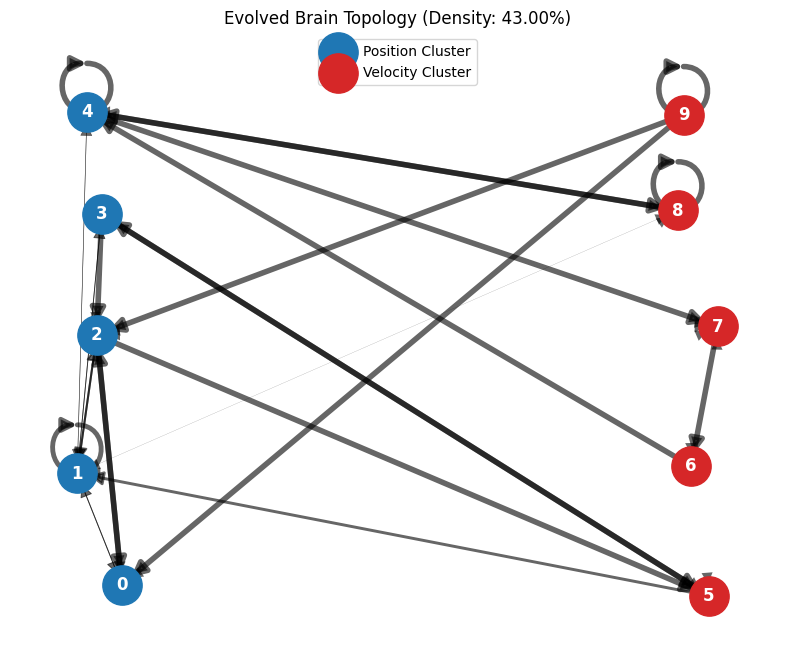

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OriginalHebbianGNN_Actor(state_dim=2, num_nodes=10, hidden_dim=32, action_dim=1).to(device)
checkpoint = torch.load('/kaggle/working/ddpg_hebbian_model.pt', map_location=device)
model.load_state_dict(checkpoint['actor'])
print("Model loaded successfully!")

# Extract the Adjacency Matrix
adj = model.get_adjacency()
# Threshold it to get binary connections (Active vs Inactive)
adj_binary = (adj > 0).float().cpu().detach().numpy()
weights = model.edge_weights.cpu().detach().numpy()

# The Raw Matrix
print("\n--- The Connection Matrix ---")
print("Rows = Source Node, Cols = Target Node")
print("Nodes 0-4: See POSITION")
print("Nodes 5-9: See VELOCITY")
print("-" * 30)

print("   " + " ".join([f"{i}" for i in range(10)]))
for i, row in enumerate(adj_binary):
    row_str = " ".join(["#" if x > 0 else "." for x in row])
    print(f"{i}: {row_str}")

# The Network Graph
try:
    plt.figure(figsize=(10, 8))
    
    # Create graph from matrix
    G = nx.DiGraph(adj_binary)
    
    # Position nodes in two distinct clusters
    pos = {}
    # Cluster 1 (Position Sensors) on the left
    for i in range(5):
        pos[i] = np.array([-1, (i - 2) * 0.5]) + np.random.rand(2) * 0.2
    # Cluster 2 (Velocity Sensors) on the right
    for i in range(5, 10):
        pos[i] = np.array([1, (i - 7) * 0.5]) + np.random.rand(2) * 0.2

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, nodelist=range(5), node_color='tab:blue', node_size=800, label="Position Cluster")
    nx.draw_networkx_nodes(G, pos, nodelist=range(5, 10), node_color='tab:red', node_size=800, label="Velocity Cluster")
    
    # Draw edges (Thickness based on Hebbian weight)
    edges = G.edges()
    edge_weights = [weights[u, v] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=np.array(edge_weights)*2, arrowsize=20, alpha=0.6)
    
    # Labels
    nx.draw_networkx_labels(G, pos, font_color='white', font_weight='bold')
    
    plt.title(f"Evolved Brain Topology (Density: {adj_binary.mean():.2%})")
    plt.legend()
    plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f"Could not generate graph plot: {e}")